# Part 1.1 - Feature Engineering for RNN Model
In this notebook, we will analyze and transform timeseries features to build a training set for an RNN. Time series representing flux value for different data collection sessions will be segmented into separate sequences and ultimately transformed into a format ready for training the RNN.


In [89]:
import warnings
warnings.filterwarnings("ignore")
import math
import cudf as gd
import pandas as pd
import numpy as np
from numba import cuda
import time
import matplotlib.pyplot as plt

from utils import scatter
%matplotlib inline

print(gd.__version__)

0.8.0+0.g8fa7bd3.dirty


In [90]:
PATH = "/raid/cjnolet/plasticc_data/"

### Read data

To begin, we'll look at how to engineer features from the raw training data. We'll load it in from a CSV format, and represent it as a Dataframe.

Thanks to the `read_csv` API, we can manually define all column names, types, etc., to optimize the reading/loading process. We'll have to skip the record headers. This can be done by setting `skiprows=1`.

After the read is complete, we can drop the columns we don't need to save memory.

In [91]:
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

train_gd = gd.read_csv('%s/training_set.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)
test_gd = gd.read_csv('%s/test_set_sample.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)

train_gd.drop_column('detected')
test_gd.drop_column('detected')

In [92]:
train_gd.head().to_pandas()

,object_id,mjd,passband,flux,flux_err
0,615,59750.421875,2,-544.810303,3.622952
1,615,59750.429688,1,-816.434387,5.553370
2,615,59750.437500,3,-471.385498,3.801213
3,615,59750.441406,4,-388.984955,11.395031
4,615,59752.406250,2,-681.858826,4.041203


### Normalization

Let's histogram the `flux` and `flux_err` values to get a feel for their distributions. 

We can use `hist()` from Pandas to generate histograms. To access the Pandas API from cuDF, we'll have to call `to_pandas()` to copy the data to the host and convert it to a Pandas Dataframe.

A quick look at the output suggests that most of the binned values occur near the zeroth bin. To exemplify the shape of the distribution, we can perform a logarithmic transformation.

A couple more details worth noting here:
- There are extreme negative values in `flux`, which cannot be log-transformed. We will need to clip them.
- The `flux_err` is entirely non-negative; so, we can apply log-transform directly

Text(0.5, 1.0, 'Original data')

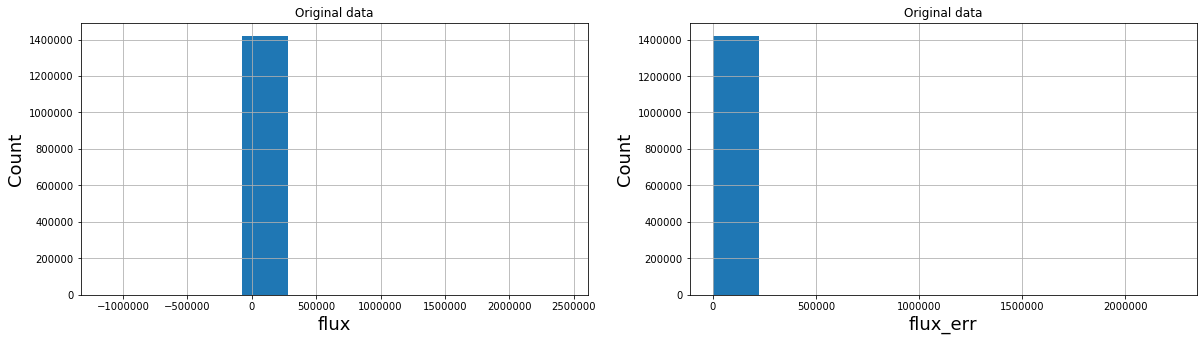

In [93]:
fig, axs = plt.subplots(1,2, figsize=(20, 5))
ax = train_gd.flux.to_pandas().hist(ax=axs[0])

ax.set_xlabel('flux', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('Original data')

ax = train_gd.flux_err.to_pandas().hist(ax=axs[1])

ax.set_xlabel('flux_err', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('Original data')

The `applymap(func)` function can be used on cuDF Series objects. 

This enables us to apply the log transform and clipped log transform in parallel on the GPU for all the values in the Series. 

In [94]:
def clip_and_log_transform(df):
    df['flux'] = df['flux'].applymap(lambda x: math.log1p(x+10) if x>-10 else 0)
    df['flux_err'] = df['flux_err'].applymap(lambda x: math.log1p(x))
    return df

train_gd = clip_and_log_transform(train_gd)
test_gd = clip_and_log_transform(test_gd)

Now let's plot the histograms of the clipped and log-transformed values to get a better idea of the data distribution

Text(0.5, 1.0, 'After log transformation')

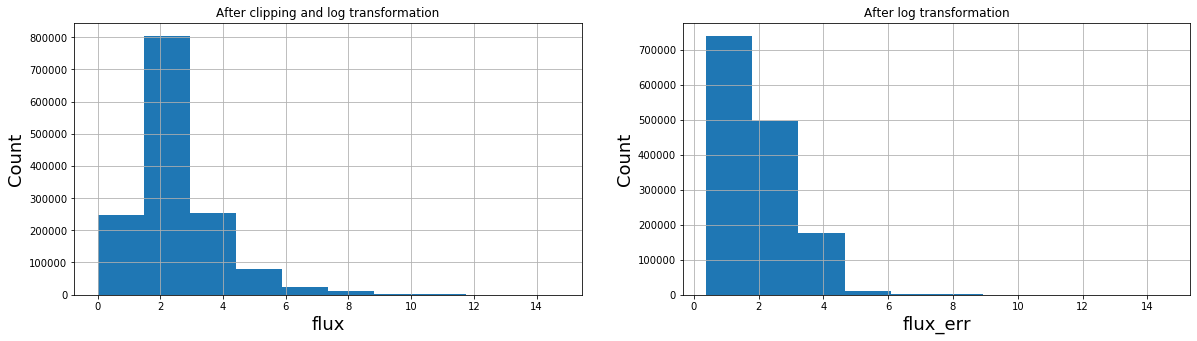

In [95]:
fig, axs = plt.subplots(1,2, figsize=(20, 5))
ax = train_gd.flux.to_pandas().hist(ax=axs[0])
ax.set_xlabel('flux', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('After clipping and log transformation')

ax = train_gd.flux_err.to_pandas().hist(ax=axs[1])
ax.set_xlabel('flux_err', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('After log transformation')

### Differentiation

First let's take look at the scatter plot of the light curve for a single object.

We want to learn how `flux` varies over timestamp `mjd`, namely $\frac{\nabla flux}{\nabla mjd}$

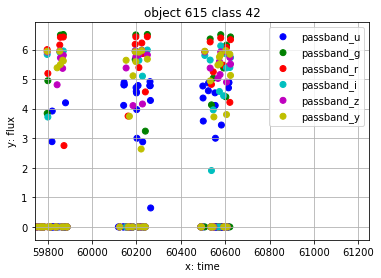

In [96]:
oid = 615
sample = train_gd[train_gd['object_id']==oid].to_pandas()
scatter(sample['mjd'].values,
        sample['flux'].values,
        values=sample['passband'].values,
        xlabel='time',ylabel='flux',title='object %d class 42'%oid)

In [97]:
train_gd = train_gd.sort_values(['object_id','mjd'])
test_gd = test_gd.sort_values(['object_id','mjd'])

We use cuDF's `groupby() - apply()` technique to group the dataframes by `object_id`. 

Rather than using `apply()` on the grouped Dataframe, we use cuDF's `apply_grouped()` so that we can run a function in parallel on each group. Our custom function will compute the deltas between timestamps.

The following function, `compute_delta()` computes the differences for `flux` and `mjd` observations.

In [98]:
def delta_in_group(val,val_delta, default):
    """
    A Numba CUDA function that diffs all the values in a single timeseries sequence
    """
    for i in range(cuda.threadIdx.x, len(val), cuda.blockDim.x):
        if i>0:
            val_delta[i] = val[i]-val[i-1]
        else:
            val_delta[i] = default

def compute_delta(df):
    for col,d in zip(['flux','mjd'],[0,180]):
        df = df.rename({col:'val'})
        df = df.groupby('object_id',method="cudf",
                        as_index=False).apply_grouped(delta_in_group,
                                  incols=['val'],
                                  outcols={'val_delta': np.float32},
                                  kwargs={'default':d},
                                  tpb=32)
        df = df.rename({'val': col})
        df = df.rename({'val_delta':'%s_delta'%col})

    return df

In [99]:
train_gd = compute_delta(train_gd)
test_gd = compute_delta(test_gd)

In [100]:
train_gd.drop_column('mjd')
test_gd.drop_column('mjd')

train_gd.drop_column('flux')
test_gd.drop_column('flux')

In [101]:
train_gd.head().to_pandas()

,object_id,passband,flux_err,flux_delta,mjd_delta
0,615,2,1.531034,0.0,180.000000
1,615,1,1.879979,0.0,0.007812
2,615,3,1.568869,0.0,0.007812
3,615,4,2.517296,0.0,0.003906
4,615,2,1.617645,0.0,1.964844


In [102]:
train_gd.head().to_pandas()

,object_id,passband,flux_err,flux_delta,mjd_delta
0,615,2,1.531034,0.0,180.000000
1,615,1,1.879979,0.0,0.007812
2,615,3,1.568869,0.0,0.007812
3,615,4,2.517296,0.0,0.003906
4,615,2,1.617645,0.0,1.964844


Lastly, we scale `mjd_delta` in proportion to the boundary threshold. This just minimizes the variance, which is helpful for training the RNN. 

Text(0.5, 1.0, 'Original')

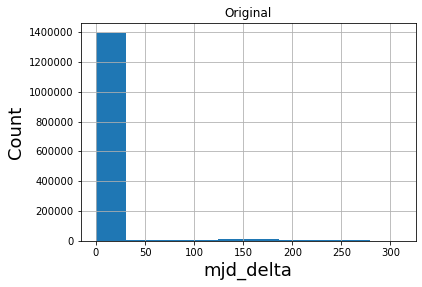

In [103]:
fig, axs = plt.subplots(1,1)
ax = train_gd.mjd_delta.to_pandas().hist()
ax.set_xlabel('mjd_delta', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('Original')

In [104]:
train_gd['mjd_delta'] /= 90 # scale mjd_delta
test_gd['mjd_delta'] /= 90

Text(0.5, 1.0, 'After scaling')

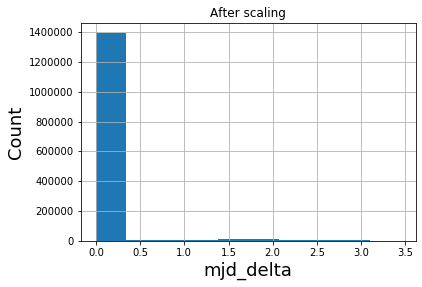

In [105]:
ax = train_gd.mjd_delta.to_pandas().hist()
ax.set_xlabel('mjd_delta', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('After scaling')

### Create step numbers for each light curve sequence

For our final engineering step, let's mark each timeseries element with a step number, so that we can preserve the order of each sequence. 

Since the train and test Dataframes are already ordered by their object ids and the time steps, we can just number the ocurrences of object ids starting at 0. 

In [106]:
train_gd.head().to_pandas()

,object_id,passband,flux_err,flux_delta,mjd_delta
0,615,2,1.531034,0.0,2.000000
1,615,1,1.879979,0.0,0.000087
2,615,3,1.568869,0.0,0.000087
3,615,4,2.517296,0.0,0.000043
4,615,2,1.617645,0.0,0.021832


In [107]:
train_pd = train_gd.to_pandas()
test_pd = test_gd.to_pandas()

Since we have converted our reference dataframe to host memory and we only need the `object_id` column of our GPU Dataframes, we can loop through all the other columns and drop them. 

In [108]:
cols = [col for col in train_gd.columns]
for col in cols:
    if col!='object_id':
        train_gd.drop_column(col)
        test_gd.drop_column(col)

We can number the steps in the GPU Dataframe by using the `groupby() - apply_grouped()` strategy we used for computing the deltas.

In [109]:
def get_order_in_group(row_id,step):
    """
    A Numba CUDA function that assigns a step value to all the elements in a single timeseries sequence
    """
    for i in range(cuda.threadIdx.x, len(row_id), cuda.blockDim.x):
        step[i] = i

def add_step(df):
    df['row_id'] = np.arange(df.shape[0])
    df = df.groupby('object_id',method="cudf").apply_grouped(get_order_in_group,incols=['row_id'],
                                  outcols={'step': np.int32},
                                  tpb=32)
    df = df.sort_values('row_id')
    return df

In [110]:
train_gd = add_step(train_gd)
test_gd = add_step(test_gd)

In [111]:
train_pd['step'] = train_gd['step'].to_pandas().values
test_pd['step'] = test_gd['step'].to_pandas().values

In [112]:
train_pd.head()

,object_id,passband,flux_err,flux_delta,mjd_delta,step
0,615,2,1.531034,0.0,2.000000,0
1,615,1,1.879979,0.0,0.000087,1
2,615,3,1.568869,0.0,0.000087,2
3,615,4,2.517296,0.0,0.000043,3
4,615,2,1.617645,0.0,0.021832,4


In [113]:
train_pd.to_pickle('train_rnn.pkl')
test_pd.to_pickle('test_rnn.pkl')

### Conclusion

In this notebook we process the light curve timseries data in order to train a RNN. 
- `object_id` and `seq_id` can be used to sample sequences from the dataframe.
- `mjd_delta` and `flux_delta` enable RNN to learn the temporal pattern of light curves.
- `passband` is an original feature and will be embedded.